In [3]:
## Basic regression: Predict fuel efficiency
# uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles.
 
!pip install -q seaborn  
!pip install -q git+https://github.com/tensorflow/docs
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.2.0-dev20200501


In [4]:
# The Auto MPG dataset
# Get the data
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 6us/step


'C:\\Users\\Nano\\.keras\\datasets\\auto-mpg.data'

In [5]:
# Import it using pandas

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
# Clean the data
 
dataset.isna().sum() # The dataset contains a few unknown values.
dataset = dataset.dropna()  # To keep this initial tutorial simple drop those rows.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})  # The "Origin" column is really categorical, not numeric. So convert that to a one-hot:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [7]:
# Split the data into train and test

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

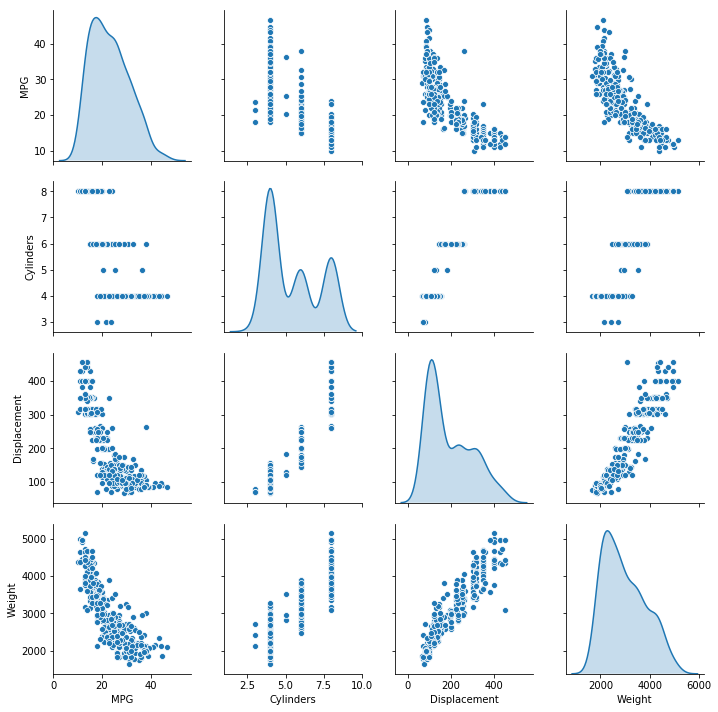

In [9]:
# Inspect the data

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [10]:
# Also look at the overall statistics:

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [11]:
# Split features from labels

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [12]:
# Normalize the data

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
# Build the model
# use a Sequential model with two densely connected hidden layers,
# and an output layer that returns a single, continuous value. 

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

In [16]:
# Inspect the model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Now try out the model. 
# Take a batch of 10 examples from the training data and call model.predict on it.

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.33516392],
       [-0.11562813],
       [-0.08999035],
       [-0.20744339],
       [ 0.0838374 ],
       [ 0.10175225],
       [ 0.10173234],
       [-0.04431229],
       [ 0.04408815],
       [ 0.31075335]], dtype=float32)

In [19]:
# Train the model
# Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()]) 


Epoch: 0, loss:574.1821,  mae:22.6427,  mse:574.1821,  val_loss:571.4834,  val_mae:22.4856,  val_mse:571.4834,  
....................................................................................................
Epoch: 100, loss:6.0025,  mae:1.7225,  mse:6.0025,  val_loss:8.3989,  val_mae:2.2280,  val_mse:8.3989,  
....................................................................................................
Epoch: 200, loss:5.0797,  mae:1.5541,  mse:5.0797,  val_loss:8.1918,  val_mae:2.2216,  val_mse:8.1918,  
....................................................................................................
Epoch: 300, loss:4.5916,  mae:1.4675,  mse:4.5916,  val_loss:8.5081,  val_mae:2.2369,  val_mse:8.5081,  
....................................................................................................
Epoch: 400, loss:4.3384,  mae:1.3760,  mse:4.3384,  val_loss:7.6244,  val_mae:2.0806,  val_mse:7.6244,  
..............................................................

In [20]:
# Visualize the model's training progress using the stats stored in the history object.

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.659633,1.028167,2.659633,8.024138,2.193280,8.024138,995
996,2.592004,1.057568,2.592004,8.086080,2.200954,8.086080,996
997,2.770786,1.048344,2.770786,7.642133,2.144280,7.642133,997
998,2.674658,1.023176,2.674658,7.601089,2.174231,7.601089,998
999,2.636002,1.058603,2.636002,8.673382,2.281838,8.673382,999


Text(0, 0.5, 'MAE [MPG]')

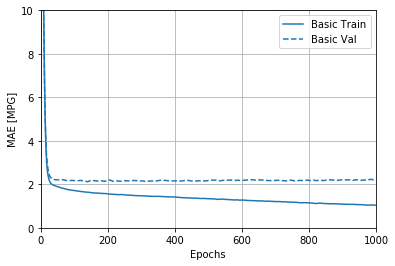

In [22]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

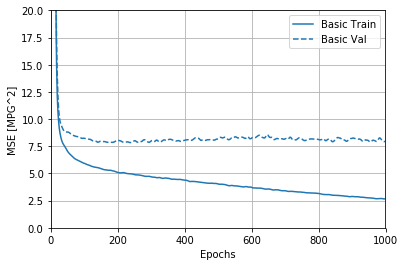

In [23]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [24]:
# This graph shows little improvement,
# We'll use an EarlyStopping callback that tests a training condition for every epoch.

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:572.6747,  mae:22.6752,  mse:572.6747,  val_loss:566.2817,  val_mae:22.4992,  val_mse:566.2817,  
.........................................................................

Text(0, 0.5, 'MAE [MPG]')

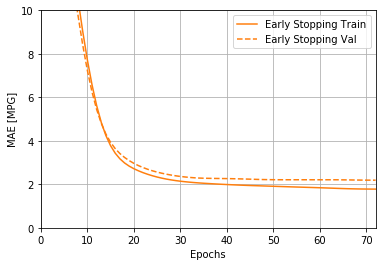

In [25]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [26]:
# the model generalizes by using the test set

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.8367 - mae: 1.8365 - mse: 5.8367
Testing set Mean Abs Error:  1.84 MPG


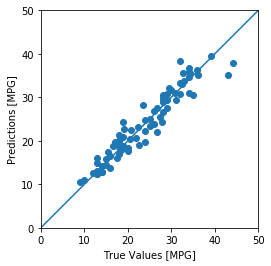

In [27]:
# Make predictions

test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


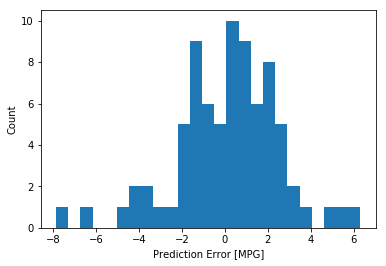

In [28]:
# It looks like our model predicts reasonably well. Let's take a look at the error distribution.

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")